In [197]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau

# metric
from sklearn.metrics import fbeta_score

import wandb

# config

In [198]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")
SURFACE_NUM = 5

CFG = {
    "DEBUG" : True,
    # exp setting
    "EXP_CATEGORY" : "makebase",
    "EXP_NAME" : "base000",
    "folds" : ["0"],

    # model
    "model_name" : "tf_efficientnet_b0",
    "inp_channels" : SURFACE_NUM + 1,
    "out_channels" : 1,
    "pretrained" : True,
    "out_indices" : [0,1,2,3,4],
 
    # data   
    "img_size": [256, 256],
    "batch_size": 32,
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "surface_num": SURFACE_NUM,
    # "TRAIN_IDX_LIST": ["1", "2"],
    "TRAIN_IDX_LIST" : ["1"],
    "VALID_IDX_LIST": ["3"],
    "TEST_IDX_LIST": ["a", "b"],

    # learning
    "n_epoch" : 10,
    "lr" : 1e-4,
    "T_max" : 10,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}

if CFG["DEBUG"]:
    CFG["n_epoch"] = 1

In [199]:
if not CFG["DEBUG"]:
    os.environ["WANDB_SILENT"] = "true"
    WANDB_CONFIG = {'competition': 'VCID', '_wandb_kernel': 'taro'}

    wandb.init(project=WANDB_CONFIG["competition"], config=CFG, group=CFG["EXP_CATEGORY"], name=CFG["EXP_NAME"])

# utils

In [200]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [201]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [202]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

# model

In [203]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        channel_nums = [320, 112, 40, 24, 16]
        self.UpConv_0 = UpConv(channel_nums[0], channel_nums[1])
        self.UpConv_1 = UpConv(channel_nums[1]*2, channel_nums[2])
        self.UpConv_2 = UpConv(channel_nums[2]*2, channel_nums[3])
        self.UpConv_3 = UpConv(channel_nums[3]*2, channel_nums[4])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        
        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            nn.Conv2d(32, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
        return output

# Dataset

In [204]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ToFloat(max_value=255),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.ToFloat(max_value=255),
    ToTensorV2(),
])


In [205]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, mode="train", transform=None):
        # get config
        self.mode = mode
        if self.mode=="train":
            self.DATADIR = CFG["TRAIN_DIR"]
            self.data_idx_list = CFG["TRAIN_IDX_LIST"]
        elif self.mode=="valid":
            self.DATADIR = CFG["TRAIN_DIR"]
            self.data_idx_list = CFG["VALID_IDX_LIST"]
        elif self.mode == "test":
            self.DATADIR = CFG["TEST_DIR"]
            self.data_idx_list = CFG["TEST_IDX_LIST"]
        self.surface_num = CFG["surface_num"]
        self.img_size = CFG["img_size"]
        self.transform = transform
        
        # get imgs
        print("initializing dataset...")
        self.imgs = []
        for idx in self.data_idx_list:
            img_path = os.path.join(self.DATADIR, idx, "mask.png")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            self.imgs.append(img)
        
        # check imgs
        for img in self.imgs:
            assert img is not None, "img is None. data path is wrong"
        # get and split surface
        self.surface_vols = self.read_surfacevols()
        for surface_vol in self.surface_vols:
            assert surface_vol is not None, "surface_vol is None. data path is wrong"
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for idx in self.data_idx_list:
                label_path = os.path.join(self.DATADIR, idx, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        print("initializing dataset done.")

    def read_surfacevols(self):
        surface_vols = []
        print("reading surface volume...")
        for img_idx in self.data_idx_list:
            surface_vol_ = None
            for i in range(self.surface_num):
                print("\r", f"reading idx : {i+1}/{self.surface_num}", end="")
                surface_path = os.path.join(self.DATADIR, img_idx, "surface_volume", f"{i:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            print(f"  => read surface volume done. [{img_idx}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        img_grid = img[grid_idx[0]*self.img_size[0]:(grid_idx[0]+1)*self.img_size[0],
                        grid_idx[1]*self.img_size[1]:(grid_idx[1]+1)*self.img_size[1]]
        return img_grid 

    def get_all_grid(self):
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = img.shape[0] // self.img_size[0]
            self.y_grid_size = img.shape[1] // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        grid_idx = self.flatten_grid[idx]
        img_idx = grid_idx[0]
        grid_idx = grid_idx[1:]
        # get img & surface_vol
        img = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        img = self.get_grid_img(img, grid_idx)
        surface_vol = self.get_grid_img(surface_vol, grid_idx)
        assert surface_vol.shape[0]==img.shape[0] and surface_vol.shape[1]==img.shape[1] , "surface_vol_list shape is not same as img shape"
        
        # concat img & surface_vol in channel axix 
        img = np.concatenate([img, surface_vol], axis=2)
        # img = np.concatenate([img*255, surface_vol], axis=2)

        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1) # (channel, h, w)
                label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1) # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            return img, label


In [206]:
transforms = A.Compose([
    A.HorizontalFlip(p=1.0),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.ToFloat(max_value=255),
    ToTensorV2(),
])

print("dataset")
dataset = VCID_Dataset(CFG, mode="train", transform=transforms)
print("dataloader")
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=0)


print("dataset")
dataset_notrans = VCID_Dataset(CFG, mode="train")
print("dataloader")
dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


dataset
initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [1]
split grid done.
initializing dataset done.
dataloader
dataset
initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [1]
split grid done.
initializing dataset done.
dataloader


batch_idx:  10
torch.Size([4, 6, 256, 256])
torch.Size([4, 1, 128, 128])
torch.Size([256, 256, 6])
torch.Size([128, 128, 1])


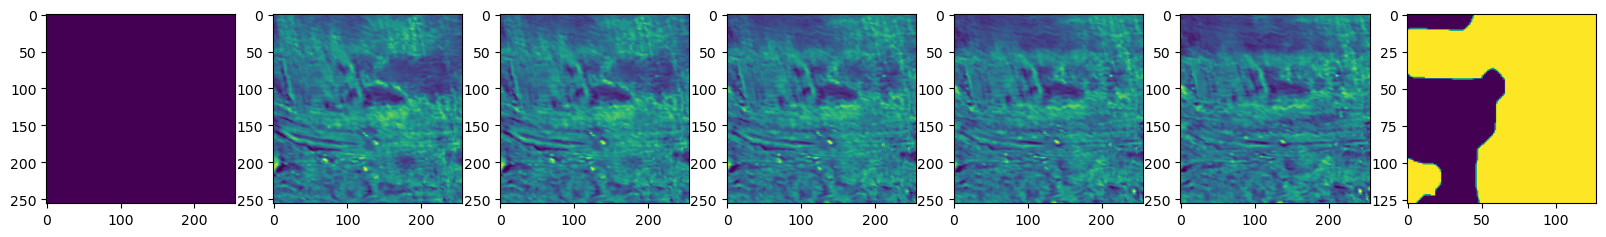

batch_idx:  10
torch.Size([4, 6, 256, 256])
torch.Size([4, 1, 128, 128])
torch.Size([256, 256, 6])
torch.Size([128, 128, 1])


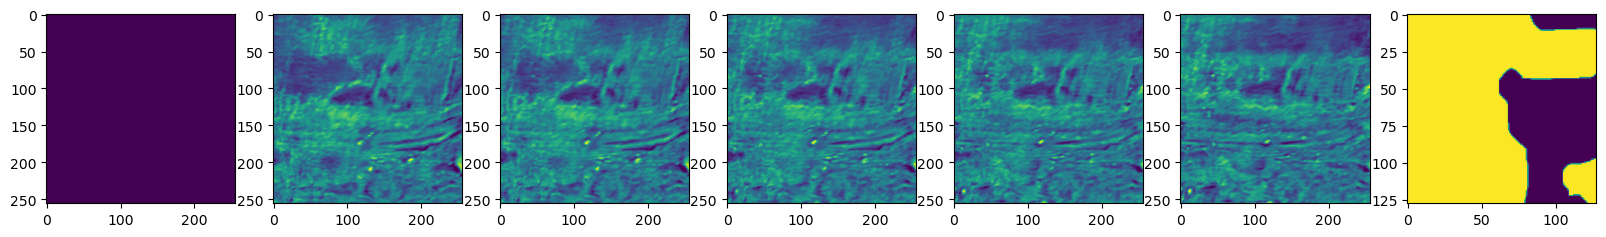

In [207]:
imshow_batch = 10

for batch_idx, (imgs, labels) in enumerate(dataloader):
    img = imgs[0].permute(1, 2, 0)
    label = labels[0].permute(1, 2, 0)
    if batch_idx < imshow_batch:
        pass
    else:
        print("batch_idx: ", batch_idx)
        print(imgs.shape)
        print(labels.shape)
        print(img.shape)
        print(label.shape)
        plt.figure(figsize=(20, 20))
        for idx in range(CFG["surface_num"]+1):
            plt.subplot(1, CFG["surface_num"]+2, idx+1)
            plt.imshow(img[:,:,idx])
        plt.subplot(1, CFG["surface_num"]+2, 2+CFG["surface_num"])
        plt.imshow(label)
        plt.show()
        break

for batch_idx, (imgs, labels) in enumerate(dataloader_notrans):
    img = imgs[0].permute(1, 2, 0)
    label = labels[0].permute(1, 2, 0)
    if batch_idx < imshow_batch:
        pass
    else:
        print("batch_idx: ", batch_idx)
        print(imgs.shape)
        print(labels.shape)
        print(img.shape)
        print(label.shape)
        plt.figure(figsize=(20, 20))
        for idx in range(CFG["surface_num"]+1):
            plt.subplot(1, CFG["surface_num"]+2, idx+1)
            plt.imshow(img[:,:,idx])
        plt.subplot(1, CFG["surface_num"]+2, 2+CFG["surface_num"])
        plt.imshow(label)
        plt.show()
        break

# train valid fn

In [208]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()     
        preds = model(images)
        
        loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()

        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('\t Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

In [209]:
def valid_fn(model, valid_loader, criterion):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []

    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds = model(images)
            loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()

        test_preds.append(preds)
        test_targets.append(targets)
        # score = matthews_corrcoef(preds, targets)
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1):
            print('\t EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    return test_targets, test_preds, losses.avg

# training loop

In [210]:
def training_loop(CFG):
    # set model & learning fn
    model = SegModel(CFG)
    model = model.to(device)
    if not CFG["DEBUG"]:
        wandb.watch(model)
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)
    for fold in CFG["folds"]:
        # separate train/valid data 
        train_dataset = VCID_Dataset(CFG, mode="train", transform=train_transforms)
        valid_dataset = VCID_Dataset(CFG, mode="valid", transform=valid_transforms)
        train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle = True,
                                    num_workers = CFG["num_workers"], pin_memory = True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = True,
                                    num_workers = CFG["num_workers"], pin_memory = True)

        # training
        best_score = -np.inf
        start_time = time.time()
        for epoch in range(1, CFG["n_epoch"] + 1):
            print(f'\t === epoch: {epoch}: training ===')
            train_loss_avg = train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler)
            valid_targets, valid_preds, valid_loss_avg = valid_fn(model, valid_loader, criterion)

            valid_score, valid_threshold = calc_cv(valid_targets, valid_preds)

            elapsed = time.time() - start_time
            print(f'\t epoch:{epoch}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}, score:{valid_score:.4f}(th={valid_threshold}) ::: time:{elapsed:.2f}s')
            scheduler.step()
            # validationスコアがbestを更新したらモデルを保存する
            if valid_score > best_score:
                best_score = valid_score
                model_name = CFG["model_name"]
                torch.save(model.state_dict(), f'{CFG["MODEL_DIR"]}/{model_name}_fold{fold}.pth')
                print(f'\t Epoch {epoch} - Save Best Score: {best_score:.4f}. Model is saved.')

    del train_loader, train_dataset, valid_loader, valid_dataset
    gc.collect()
    torch.cuda.empty_cache()

# main

In [211]:
training_loop(CFG)
if not CFG["DEBUG"]:
    wandb.finish()

initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [1]
split grid done.
initializing dataset done.
initializing dataset...
reading surface volume...
 reading idx : 5/5  => read surface volume done. [3]
split grid done.
initializing dataset done.
	 === epoch: 1: training ===
	 Epoch: [1][0/16] Elapsed 0m 0s (remain 0m 7s) Loss: 11.8575(11.8575) 
	 Epoch: [1][15/16] Elapsed 0m 2s (remain 0m 0s) Loss: -11.4930(-1.0036) 
	 EVAL: [0/14] Elapsed 0m 0s (remain 0m 2s) Loss: 14.0823(14.0823) 
	 EVAL: [13/14] Elapsed 0m 2s (remain 0m 0s) Loss: 3.7046(8.2719) 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: setting an array element with a sequence.